In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Importing the data

In [2]:
raw_data = pd.read_csv('Index2018.csv')
raw_data.head()
# market indexes

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Transform raw data into Time-Series Data

In [3]:
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace = True)
df = df.asfreq('b') # 'b' - business days
df.fillna(method = 'ffill', inplace = True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Using Returns

In [5]:
# create returns out of prices
# returns = (p(t) - p(t-1)) / p(t-1)
df['ftse_returns'] = df.ftse.pct_change(1).mul(100)
df.head()

,spx,dax,ftse,nikkei,ftse_returns
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44,-0.156704
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166


In [6]:
# squared returns
df['ftse_sq_returns'] = df.ftse_returns.pow(2)
df.head()

,spx,dax,ftse,nikkei,ftse_returns,ftse_sq_returns
date,,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44,-0.156704,0.024556
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229,0.607198
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988,1.495700
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166,0.126854


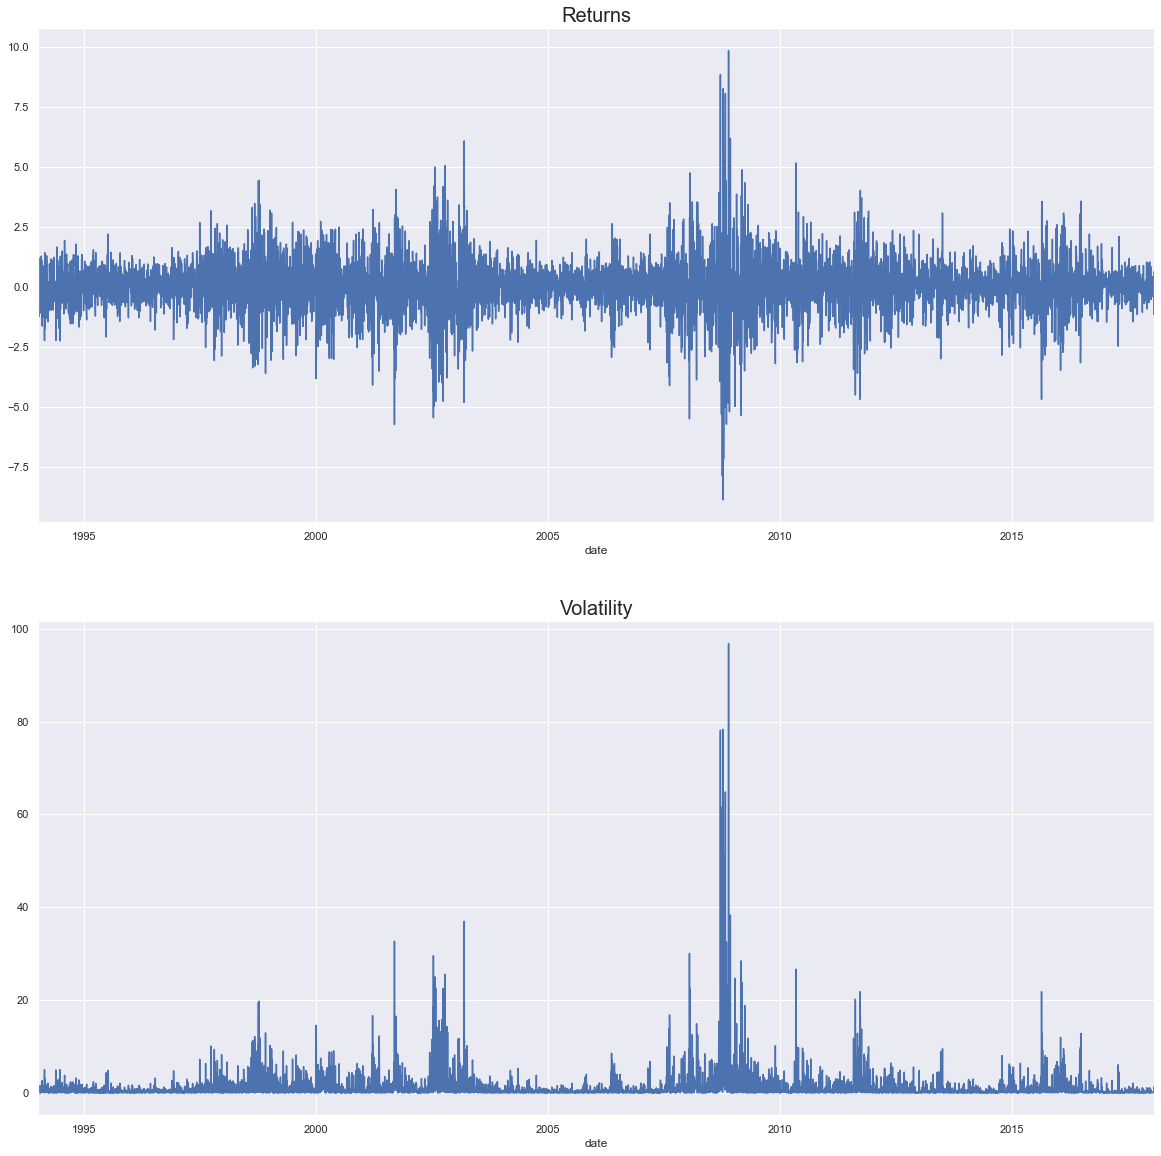

In [7]:
# returns vs squared returns

plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)
df.ftse_returns.plot()
plt.title('Returns', size = 20)

plt.subplot(2, 1, 2)
df.ftse_sq_returns.plot()
plt.title('Volatility', size = 20)
plt.show()

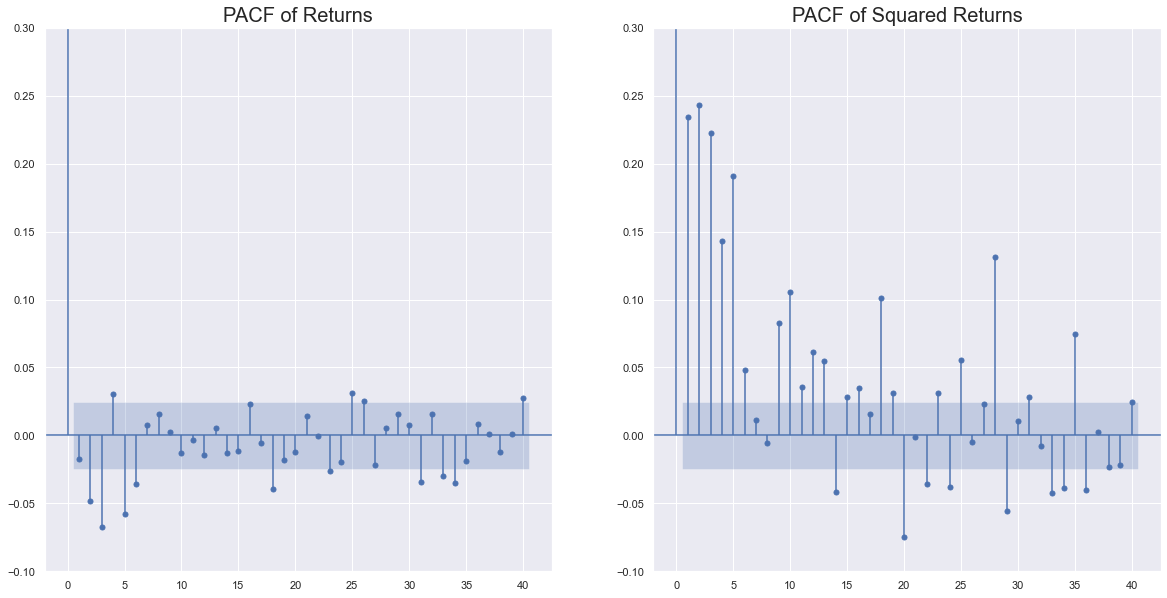

In [8]:
import statsmodels.graphics.tsaplots as sgt

# PACF of returns vs squared returns
fig, ax = plt.subplots(1,2,figsize=(20, 10))

sgt.plot_pacf(df.ftse_returns.iloc[1:], lags = 40, ax = ax[0])
ax[0].title.set_text('PACF of Returns')
ax[0].title.set_size(20)
ax[0].set_ylim([-0.1, 0.3])

sgt.plot_pacf(df.ftse_sq_returns.iloc[1:], lags = 40, ax = ax[1])
ax[1].title.set_text('PACF of Squared Returns')
ax[1].title.set_size(20)
ax[1].set_ylim([-0.1, 0.3])
plt.show()

## Simple ARCH(1) model

In [9]:
from arch import arch_model

arch_1 = arch_model(df.ftse_returns.iloc[1:], 
                    mean = 'Constant', 
                    vol = 'ARCH', 
                    p = 1)

results_arch_1 = arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 38476.766788342204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14503.543820834615
Iteration:      3,   Func. Count:     20,   Neg. LLF: 9420.535229295128
Iteration:      4,   Func. Count:     26,   Neg. LLF: 9236.603944302544
Iteration:      5,   Func. Count:     30,   Neg. LLF: 9236.603925076519
Iteration:      6,   Func. Count:     33,   Neg. LLF: 9236.603925076626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9236.603925076519
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           ftse_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9236.60
Distribution:                  Normal   AIC:                           18479.2
Method:            Maximum Likelihood   BIC:                           18499.4
                                        No. Observations:                 6276
Date:                Sat, Nov 19 2022   Df Residuals:                     6275
Time:                        02:46:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0350  1.366e-02      2.564  1.036e-02 [8.244e-03,6.178e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8175  3.463e-02     23.607 3.268e-123 [  0.750,  0.885]
alpha[1]       0.3818  4.570e-02      8.355  6.529e-17 [  0.292,  0.471]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag ARCH Models

In [10]:
arch_2 = arch_model(df.ftse_returns.iloc[1:], 
                    mean = 'Constant', 
                    vol = 'ARCH', 
                    p = 2)

results_arch_2 = arch_2.fit(update_freq = 2)
results_arch_2.summary()

# comparing Log-Likelihood and AIC we can conclude that ARCH(2) > ARCH(1)

Iteration:      2,   Func. Count:     16,   Neg. LLF: 11256.919975964955
Iteration:      4,   Func. Count:     31,   Neg. LLF: 9224.230526881416
Iteration:      6,   Func. Count:     43,   Neg. LLF: 8984.121962488998
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8984.121962488998
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           ftse_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8984.12
Distribution:                  Normal   AIC:                           17976.2
Method:            Maximum Likelihood   BIC:                           18003.2
                                        No. Observations:                 6276
Date:                Sat, Nov 19 2022   Df Residuals:                     6275
Time:                        02:46:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0422  1.185e-02      3.565  3.638e-04 [1.902e-02,6.546e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6239  2.918e-02     21.377 2.193e-101 [  0.567,  0.681]
alpha[1]       0.2368  3.218e-02      7.358  1.865e-13 [  0.174,  0.300]
alpha[2]       0.2693  3.206e-02      8.401  4.426e-17 [  0.207,  0.332]
========================================================================

Covariance estimator: robust
"""

In [11]:
arch_3 = arch_model(df.ftse_returns.iloc[1:], 
                    mean = 'Constant', 
                    vol = 'ARCH', 
                    p = 3)

results_arch_3 = arch_3.fit(update_freq = 2)
results_arch_3.summary()

# comparing Log-Likelihood and AIC we can conclude that ARCH(3) > ARCH(2)

Iteration:      2,   Func. Count:     18,   Neg. LLF: 14517.958410458305
Iteration:      4,   Func. Count:     34,   Neg. LLF: 9035.399711048492
Iteration:      6,   Func. Count:     49,   Neg. LLF: 9014.23126462198
Iteration:      8,   Func. Count:     64,   Neg. LLF: 8764.836368367827
Iteration:     10,   Func. Count:     75,   Neg. LLF: 8764.83636724879
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8764.8363672489
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:           ftse_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8764.84
Distribution:                  Normal   AIC:                           17539.7
Method:            Maximum Likelihood   BIC:                           17573.4
                                        No. Observations:                 6276
Date:                Sat, Nov 19 2022   Df Residuals:                     6275
Time:                        02:46:40   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0475  1.123e-02      4.228  2.356e-05 [2.548e-02,6.951e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4532  2.280e-02     19.882  5.822e-88 [  0.409,  0.498]
alpha[1]       0.1665  2.427e-02      6.859  6.948e-12 [  0.119,  0.214]
alpha[2]       0.2074  2.257e-02      9.190  3.944e-20 [  0.163,  0.252]
alpha[3]       0.2792  2.978e-02      9.374  6.992e-21 [  0.221,  0.338]
========================================================================

Covariance estimator: robust
"""